<a href="https://colab.research.google.com/github/flahbocchino/farmtech-fase7-grupoFlavia-/blob/main/fase7_notebook/FarmTech_Fase7_IrAlem_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random


In [ ]:
# Gerar dados simples para o Ir Além (10 talhões simulados)
dados = pd.DataFrame({
    "talhao_id": range(1, 11),
    "area_ha":    [5, 8, 6, 10, 4, 7, 3, 9, 2, 5],
    "agua_m3":    [800, 1200, 900, 1500, 600, 1100, 500, 1400, 400, 750],
    "fertilizante_kg": [200, 320, 250, 400, 180, 300, 150, 380, 120, 220],
    "produtividade_sacas": [150, 260, 200, 330, 130, 240, 100, 310, 80, 170],
    "custo_total": [5000, 7800, 6200, 9500, 4300, 7000, 3500, 8900, 3000, 5200]
})

# Salvar a entrada em CSV (requisito do enunciado)
dados.to_csv("ir_alem_dados.csv", index=False)

dados


,talhao_id,area_ha,agua_m3,fertilizante_kg,produtividade_sacas,custo_total
0,1,5,800,200,150,5000
1,2,8,1200,320,260,7800
2,3,6,900,250,200,6200
3,4,10,1500,400,330,9500
4,5,4,600,180,130,4300
5,6,7,1100,300,240,7000
6,7,3,500,150,100,3500
7,8,9,1400,380,310,8900
8,9,2,400,120,80,3000
9,10,5,750,220,170,5200


In [ ]:
# Ler a entrada do arquivo criado (reprodutibilidade)
df = pd.read_csv("ir_alem_dados.csv")
df


,talhao_id,area_ha,agua_m3,fertilizante_kg,produtividade_sacas,custo_total
0,1,5,800,200,150,5000
1,2,8,1200,320,260,7800
2,3,6,900,250,200,6200
3,4,10,1500,400,330,9500
4,5,4,600,180,130,4300
5,6,7,1100,300,240,7000
6,7,3,500,150,100,3500
7,8,9,1400,380,310,8900
8,9,2,400,120,80,3000
9,10,5,750,220,170,5200


In [ ]:
# Restrições do problema (você pode ajustar depois)
LIMITE_AGUA = 6000   # m³
LIMITE_CUSTO = 30000 # reais aproximadamente


In [ ]:
# ============================
# Funções do Algoritmo Genético - VERSÃO 1 (baseline)
# Seleção por roleta, crossover de 1 ponto, mutação simples
# ============================

def avaliar_individuo(individuo, df, limite_agua, limite_custo):
    """
    individuo: array/list binário (0/1) indicando se cada talhão foi escolhido
    df: DataFrame com as colunas agua_m3, custo_total, produtividade_sacas
    """
    mask = np.array(individuo) == 1
    agua_total = df.loc[mask, "agua_m3"].sum()
    custo_total = df.loc[mask, "custo_total"].sum()
    produtividade_total = df.loc[mask, "produtividade_sacas"].sum()

    # Penalização se passar dos limites
    if (agua_total > limite_agua) or (custo_total > limite_custo):
        # penaliza fortemente
        return -1_000_000 + (limite_agua - agua_total) + (limite_custo - custo_total)
    else:
        # objetivo: maximizar produtividade
        return produtividade_total


def criar_individuo(n_genes):
    # vetor binário aleatório
    return [random.randint(0, 1) for _ in range(n_genes)]


def criar_populacao(tam_pop, n_genes):
    return [criar_individuo(n_genes) for _ in range(tam_pop)]


def selecao_roleta(pop, fitnesses):
    # Normalizar fitness para ser positivo
    min_fit = min(fitnesses)
    shift = -min_fit + 1 if min_fit <= 0 else 0
    fits_pos = [f + shift for f in fitnesses]
    soma = sum(fits_pos)
    if soma == 0:
        # tudo igual, escolhe aleatório
        return random.choice(pop), random.choice(pop)

    probs = [f/soma for f in fits_pos]
    # Escolhe dois pais de acordo com as probabilidades
    pais = np.random.choice(len(pop), size=2, replace=False, p=probs)
    return pop[pais[0]], pop[pais[1]]


def crossover_1_ponto(pai1, pai2, taxa_crossover=0.9):
    if random.random() > taxa_crossover:
        return pai1[:], pai2[:]
    ponto = random.randint(1, len(pai1)-1)
    filho1 = pai1[:ponto] + pai2[ponto:]
    filho2 = pai2[:ponto] + pai1[ponto:]
    return filho1, filho2


def mutacao_simples(individuo, taxa_mutacao=0.05):
    for i in range(len(individuo)):
        if random.random() < taxa_mutacao:
            individuo[i] = 1 - individuo[i]  # inverte 0/1
    return individuo


def executar_ga_baseline(df, limite_agua, limite_custo,
                         tam_pop=30, n_geracoes=50,
                         taxa_crossover=0.9, taxa_mutacao=0.05):

    n_genes = len(df)
    pop = criar_populacao(tam_pop, n_genes)

    melhor_ind = None
    melhor_fit = -1e9
    historico_melhor = []

    for ger in range(n_geracoes):
        fitnesses = [avaliar_individuo(ind, df, limite_agua, limite_custo)
                     for ind in pop]

        # Atualiza melhor global
        for ind, fit in zip(pop, fitnesses):
            if fit > melhor_fit:
                melhor_fit = fit
                melhor_ind = ind[:]

        historico_melhor.append(melhor_fit)

        # nova população
        nova_pop = []
        while len(nova_pop) < tam_pop:
            pai1, pai2 = selecao_roleta(pop, fitnesses)
            filho1, filho2 = crossover_1_ponto(pai1, pai2, taxa_crossover)
            filho1 = mutacao_simples(filho1, taxa_mutacao)
            filho2 = mutacao_simples(filho2, taxa_mutacao)
            nova_pop.extend([filho1, filho2])

        pop = nova_pop[:tam_pop]

    return melhor_ind, melhor_fit, historico_melhor


In [ ]:
# ============================
# Funções do Algoritmo Genético - VERSÃO 1 (baseline)
# Seleção por roleta, crossover de 1 ponto, mutação simples
# ============================

def avaliar_individuo(individuo, df, limite_agua, limite_custo):
    """
    individuo: array/list binário (0/1) indicando se cada talhão foi escolhido
    df: DataFrame com as colunas agua_m3, custo_total, produtividade_sacas
    """
    mask = np.array(individuo) == 1
    agua_total = df.loc[mask, "agua_m3"].sum()
    custo_total = df.loc[mask, "custo_total"].sum()
    produtividade_total = df.loc[mask, "produtividade_sacas"].sum()

    # Penalização se passar dos limites
    if (agua_total > limite_agua) or (custo_total > limite_custo):
        # penaliza fortemente
        return -1_000_000 + (limite_agua - agua_total) + (limite_custo - custo_total)
    else:
        # objetivo: maximizar produtividade
        return produtividade_total


def criar_individuo(n_genes):
    # vetor binário aleatório
    return [random.randint(0, 1) for _ in range(n_genes)]


def criar_populacao(tam_pop, n_genes):
    return [criar_individuo(n_genes) for _ in range(tam_pop)]


def selecao_roleta(pop, fitnesses):
    # Normalizar fitness para ser positivo
    min_fit = min(fitnesses)
    shift = -min_fit + 1 if min_fit <= 0 else 0
    fits_pos = [f + shift for f in fitnesses]
    soma = sum(fits_pos)
    if soma == 0:
        # tudo igual, escolhe aleatório
        return random.choice(pop), random.choice(pop)

    probs = [f/soma for f in fits_pos]
    # Escolhe dois pais de acordo com as probabilidades
    pais = np.random.choice(len(pop), size=2, replace=False, p=probs)
    return pop[pais[0]], pop[pais[1]]


def crossover_1_ponto(pai1, pai2, taxa_crossover=0.9):
    if random.random() > taxa_crossover:
        return pai1[:], pai2[:]
    ponto = random.randint(1, len(pai1)-1)
    filho1 = pai1[:ponto] + pai2[ponto:]
    filho2 = pai2[:ponto] + pai1[ponto:]
    return filho1, filho2


def mutacao_simples(individuo, taxa_mutacao=0.05):
    for i in range(len(individuo)):
        if random.random() < taxa_mutacao:
            individuo[i] = 1 - individuo[i]  # inverte 0/1
    return individuo


def executar_ga_baseline(df, limite_agua, limite_custo,
                         tam_pop=30, n_geracoes=50,
                         taxa_crossover=0.9, taxa_mutacao=0.05):

    n_genes = len(df)
    pop = criar_populacao(tam_pop, n_genes)

    melhor_ind = None
    melhor_fit = -1e9
    historico_melhor = []

    for ger in range(n_geracoes):
        fitnesses = [avaliar_individuo(ind, df, limite_agua, limite_custo)
                     for ind in pop]

        # Atualiza melhor global
        for ind, fit in zip(pop, fitnesses):
            if fit > melhor_fit:
                melhor_fit = fit
                melhor_ind = ind[:]

        historico_melhor.append(melhor_fit)

        # nova população
        nova_pop = []
        while len(nova_pop) < tam_pop:
            pai1, pai2 = selecao_roleta(pop, fitnesses)
            filho1, filho2 = crossover_1_ponto(pai1, pai2, taxa_crossover)
            filho1 = mutacao_simples(filho1, taxa_mutacao)
            filho2 = mutacao_simples(filho2, taxa_mutacao)
            nova_pop.extend([filho1, filho2])

        pop = nova_pop[:tam_pop]

    return melhor_ind, melhor_fit, historico_melhor


In [ ]:
melhor_ind_baseline, melhor_fit_baseline, hist_baseline = executar_ga_baseline(
    df,
    limite_agua=LIMITE_AGUA,
    limite_custo=LIMITE_CUSTO,
    tam_pop=40,
    n_geracoes=80,
    taxa_crossover=0.9,
    taxa_mutacao=0.05
)

melhor_ind_baseline, melhor_fit_baseline


([0, 0, 0, 1, 1, 1, 0, 1, 0, 0], np.int64(1010))

In [ ]:
# ============================
# Versão 2 do GA
# Seleção por torneio + mutação mais forte
# ============================

def selecao_torneio(pop, fitnesses, tamanho_torneio=3):
    indices = list(range(len(pop)))
    escolhidos = random.sample(indices, tamanho_torneio)
    # pega o melhor dentro do torneio
    melhor_idx = max(escolhidos, key=lambda i: fitnesses[i])
    # escolhe outro torneio para o segundo pai
    escolhidos2 = random.sample(indices, tamanho_torneio)
    melhor_idx2 = max(escolhidos2, key=lambda i: fitnesses[i])
    return pop[melhor_idx], pop[melhor_idx2]


def mutacao_forte(individuo, taxa_mutacao=0.15):
    # taxa maior + chance de mutar vários genes
    for i in range(len(individuo)):
        if random.random() < taxa_mutacao:
            individuo[i] = 1 - individuo[i]
    return individuo


def executar_ga_torneio(df, limite_agua, limite_custo,
                        tam_pop=30, n_geracoes=50,
                        taxa_crossover=0.9, taxa_mutacao=0.15):

    n_genes = len(df)
    pop = criar_populacao(tam_pop, n_genes)

    melhor_ind = None
    melhor_fit = -1e9
    historico_melhor = []

    for ger in range(n_geracoes):
        fitnesses = [avaliar_individuo(ind, df, limite_agua, limite_custo)
                     for ind in pop]

        for ind, fit in zip(pop, fitnesses):
            if fit > melhor_fit:
                melhor_fit = fit
                melhor_ind = ind[:]

        historico_melhor.append(melhor_fit)

        nova_pop = []
        while len(nova_pop) < tam_pop:
            pai1, pai2 = selecao_torneio(pop, fitnesses, tamanho_torneio=3)
            filho1, filho2 = crossover_1_ponto(pai1, pai2, taxa_crossover)
            filho1 = mutacao_forte(filho1, taxa_mutacao)
            filho2 = mutacao_forte(filho2, taxa_mutacao)
            nova_pop.extend([filho1, filho2])

        pop = nova_pop[:tam_pop]

    return melhor_ind, melhor_fit, historico_melhor


In [ ]:
melhor_ind_torneio, melhor_fit_torneio, hist_torneio = executar_ga_torneio(
    df,
    limite_agua=LIMITE_AGUA,
    limite_custo=LIMITE_CUSTO,
    tam_pop=40,
    n_geracoes=80,
    taxa_crossover=0.9,
    taxa_mutacao=0.15
)

melhor_ind_torneio, melhor_fit_torneio


([0, 0, 1, 1, 0, 0, 0, 1, 0, 1], np.int64(1010))

In [ ]:
print("Baseline (roleta) - melhor produtividade:", melhor_fit_baseline)
print("Torneio + mutação forte - melhor produtividade:", melhor_fit_torneio)

if melhor_fit_torneio > melhor_fit_baseline:
    print(">>> A versão com torneio e mutação forte foi MELHOR.")
else:
    print(">>> A versão baseline com roleta foi melhor ou equivalente.")


Baseline (roleta) - melhor produtividade: 1010
Torneio + mutação forte - melhor produtividade: 1010
>>> A versão baseline com roleta foi melhor ou equivalente.


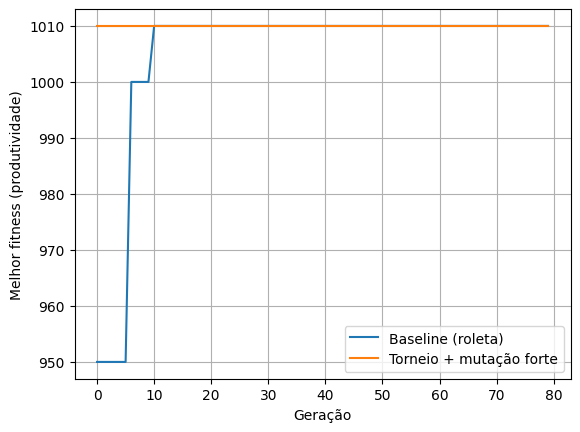

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist_baseline, label="Baseline (roleta)")
plt.plot(hist_torneio, label="Torneio + mutação forte")
plt.xlabel("Geração")
plt.ylabel("Melhor fitness (produtividade)")
plt.legend()
plt.grid(True)
plt.show()


### Análise do “Ir além” – Algoritmo Genético

**O que mudou entre as versões**

- **Seleção**
  - **Baseline:** seleção por roleta, em que cada indivíduo é escolhido de forma proporcional ao seu fitness.
  - **Versão “Ir além”:** seleção por **torneio**, onde alguns indivíduos são sorteados e apenas o melhor do grupo é escolhido. Isso aumenta a pressão seletiva (os mais produtivos têm mais chance de se reproduzir).

- **Mutação**
  - **Baseline:** mutação mais “fraca”, com menor taxa/intensidade de alteração dos genes.
  - **Versão “Ir além”:** **mutação mais forte**, permitindo mudanças maiores em cada geração e, portanto, mais exploração do espaço de soluções.

---

**Produtividade final**

- No gráfico, o baseline (azul) começa com um melhor fitness em torno de **955** e vai subindo até aproximadamente **1010** depois de algumas gerações.
- A versão com **torneio + mutação forte** (laranja) já aparece praticamente em **1010** desde o início e se mantém nesse patamar até o fim.
- Ou seja: **a produtividade máxima final é a mesma** (~1010) nas duas versões.  
  O ganho da versão “Ir além” não é em valor final, e sim em **chegar mais rápido ao melhor nível de produtividade**.

---

**Tempo e convergência**

- O **baseline** precisa de cerca de **8–10 gerações** para atingir o melhor fitness e estabilizar.
- A versão com **torneio + mutação forte** já atinge o melhor fitness **nas primeiras gerações** e a curva fica praticamente reta depois disso.
- Isso indica:
  - **Convergência mais rápida** e estável na versão “Ir além”.
  - Menos oscilações depois de encontrar a boa solução, mas também **pouca exploração adicional** após achar esse ótimo (linha laranja bem plana).

Em resumo, o “Ir além” não aumentou o melhor resultado possível, mas deixou o algoritmo **mais eficiente em tempo de convergência**, chegando ao mesmo nível de produtividade de forma muito mais rápida.
